In [ ]:
import tensorflow as tf

tf.__version__

'2.9.2'

In [ ]:
mnist_data = tf.keras.datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist_data.load_data()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [ ]:
for elem in X_train[0]:
    print("".join(["1" if e > 0 else "0" for e in elem]))

0000000000000000000000000000
0000000000000000000000000000
0000000000000000000000000000
0000000000000000000000000000
0000000000000000000000000000
0000000000001111111111110000
0000000011111111111111110000
0000000111111111111111100000
0000000111111111110000000000
0000000011111110110000000000
0000000001111100000000000000
0000000000011110000000000000
0000000000011110000000000000
0000000000001111110000000000
0000000000000111111000000000
0000000000000011111100000000
0000000000000001111100000000
0000000000000000011110000000
0000000000000011111110000000
0000000000001111111100000000
0000000000111111111000000000
0000000011111111110000000000
0000001111111111000000000000
0000111111111100000000000000
0000111111110000000000000000
0000000000000000000000000000
0000000000000000000000000000
0000000000000000000000000000


In [ ]:
# [0, 255] -> [0, 1]
X_train, X_test = X_train / 255., X_test / 255.

In [ ]:
from tensorflow.keras.utils import to_categorical

y_train_encoded, y_test_encoded = to_categorical(y_train), to_categorical(y_test)
y_train_encoded.shape, y_test_encoded.shape

((60000, 10), (10000, 10))

In [ ]:
X_train_flatten, X_test_flatten = X_train.reshape([X_train.shape[0], -1]), X_test.reshape([X_test.shape[0], -1])
X_train_flatten.shape, X_test_flatten.shape

((60000, 784), (10000, 784))

## Activation Function

In [ ]:
import numpy as np

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T
    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

## Loss

In [ ]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(
        np.log(y[np.arange(batch_size), t] + 1e-7) / batch_size
    )

## Numerical Gradient

In [ ]:
def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)

    for idx in range(x.shape[0]):
        tmp_val = x[idx]

        # f(x+h)
        x[idx] = tmp_val + h
        fxh1 = f(x)

        # f(x-h)
        x[idx] = tmp_val - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2 * h)
    return grad

# TwoLayerNet

In [ ]:
class TwoLayerNet:
    # typing hint
    def __init__(self, input_size: int, hidden_size: int, output_size: int, weight_init_std: float = 0.01):
        self.params = dict()
        self.params["W1"] = np.random.randn(input_size, hidden_size) * weight_init_std
        self.params["b1"] = np.zeros(hidden_size)
        self.params["W2"] = np.random.randn(hidden_size, output_size) * weight_init_std
        self.params["b2"] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params["W1"], self.params["W2"]
        b1, b2 = self.params["b1"], self.params["b2"]

        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)

        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)

        return y

    # x: 입력 데이터, t: 정답 데이터
    def loss(self, x, t):
        y = self.predict(x)
        return cross_entropy_error(y, t)

    def numerical_gradient(self, x: np.array, t) -> dict:
        loss_W = lambda W: self.loss(x, t)

        # grads = dict()
        # grads["W1"] = numerical_gradient(loss_W, self.params["W1"])
        # grads["b1"] = numerical_gradient(loss_W, self.params["b1"])
        # grads["W2"] = numerical_gradient(loss_W, self.params["W2"])
        # grads["b2"] = numerical_gradient(loss_W, self.params["b2"])
        return {
            _key: numerical_gradient(loss_W, self.params[_key]) for _key in (
                "W1", "b1", "W2", "b2"
            )
        }

    def gradient(self, x, t):
        W1, W2 = self.params["W1"], self.params["W2"]
        b1, b2 = self.params["b1"], self.params["b2"]

        grads = dict()
        batch_num = x.shape[0]

        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)

        # backward
        dy = (y - t) / batch_num
        grads["W2"] = np.dot(z1.T, dy)
        grads["b2"] = np.sum(dy, axis=0)

        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads["W1"] = np.dot(x.T, dz1)
        grads["b1"] = np.sum(dz1, axis=0)
        
        return grads

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1) # Neural Network가 예측한 0~9 사이의 숫자
        t = np.argmax(t, axis=1)

        acc = np.sum(y == t) / float(x.shape[0])
        return acc

---
## 20230117

In [ ]:
from tqdm.auto import tqdm
import time

In [ ]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)
network

In [ ]:
mask = np.random.choice(10, 3)
a = np.array([i+1 for i in range(10)])
mask, a

(array([4, 3, 0]), array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]))

In [ ]:
a[mask]

array([5, 4, 1])

In [ ]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)
train_size = X_train_flatten.shape[0] # 60000

# hyperparameter tuning
iters_num = 1
batch_size = 100
learning_rate = 0.1

history = dict(
    train_acc=list(),
    test_acc=list(),
)

start_time = time.time()

for i in tqdm(range(iters_num)):

    # Batch 데이터 만들기
    # SGD(Stochastic Gradient Descent) - Mini Batch
    batch_mask = np.random.choice(train_size, batch_size)
    X_batch = X_train_flatten[batch_mask]
    y_batch = y_train_encoded[batch_mask]

    # Train Model
    grads = network.gradient(X_batch, y_batch)
    # network.params["W1"] = network.params["W1"] - learning_rate * grads["W1"]
    # network.params["W2"] = network.params["W2"] - learning_rate * grads["W2"]
    # network.params["b1"] = network.params["b1"] - learning_rate * grads["b1"]    
    # network.params["b2"] = network.params["b2"] - learning_rate * grads["b2"]
    for _key in ("W1", "W2", "b1", "b2"):
        network.params[_key] -= learning_rate * grads[_key]

    train_acc = network.accuracy(X_batch, y_batch)
    test_acc = network.accuracy(X_test_flatten, y_test_encoded)
    
    # log history
    history["train_acc"].append(train_acc)
    history["test_acc"].append(test_acc)

train_time = "%.4f" % (time.time() - start_time)
print("time occured: ", train_time)

  0%|          | 0/1 [00:00<?, ?it/s]

time occured:  0.2249


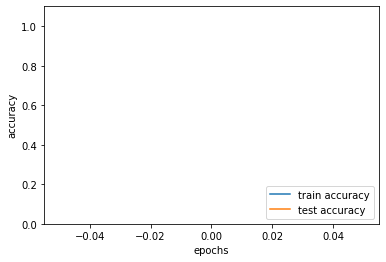

In [ ]:
# plot history
import matplotlib.pyplot as plt

x = np.arange(len(history["train_acc"]))
plt.plot(x, history["train_acc"], label="train accuracy")
plt.plot(x, history["test_acc"], label="test accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.1)
plt.legend(loc="lower right")

plt.show()

In [ ]:
history["train_acc"][-1], history["test_acc"][-1]

(0.11, 0.0974)

In [ ]:
network.accuracy(X_train_flatten, y_train_encoded)

0.09751666666666667

---

## Computational Graph


In [ ]:
class AddLayer:
    def __init__(self):
        pass
    
    def forward(self, x, y):
        return x + y

    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1
        return dx, dy

class MultiLayer:
    def __init__(self):
        self.x = None
        self.y = None

    def forward(self, x, y):
        self.x = x
        self.y = y
        return x * y

    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x
        return dx, dy   

In [ ]:
apple = 100
apple_num = 2
tax = 1.1

mul_apple_layer = MultiLayer()
mul_tax_layer = MultiLayer()

apple_price = mul_apple_layer.forward(apple, apple_num) # apple * apple_num
price = mul_tax_layer.forward(apple_price, tax)

print(price)

220.00000000000003


In [ ]:
d_price = 10000
d_apple_pirce, d_tax = mul_tax_layer.backward(d_price)
d_apple, d_apple_num = mul_apple_layer.backward(d_apple_pirce)

print("d_apple_pirce: ", d_apple_pirce)
print("d_tax: ", d_tax)
print("d_apple: ", d_apple)
print("d_apple_num: ", d_apple_num)

d_apple_pirce:  11000.0
d_tax:  2000000
d_apple:  22000.0
d_apple_num:  1100000.0


## Layer Classes

In [ ]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        return dx

In [ ]:
x = np.array([-1, 0, 1])
chk = (x <= 0)

In [ ]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx

class LeakyRelu:
    def __init__(self, a=.1):
        self.mask = None
        self.a = a

    def forward(self, x):
        self.mask = (x <= 0)
        out = np.array([
            elem if elem > 0 else elem * self.a for elem in x
        ])
        return out

    def backward(self, dout):
        dout[self.mask] = self.a
        dx = dout
        return dx

In [ ]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        return dx

## TwoLayerNet (Backpropagation)

In [ ]:
alist = [[1, 2], [3, 4]]

for _, x2 in alist:
    print(x2)

2
4


In [ ]:
from collections import OrderedDict

class TwoLayerNet:
    def __init__(self, input_size: int, hidden_size: int, output_size: int, weight_init_std: float = 0.01):
        self.params = dict()
        self.params["W1"] = weight_init_std + np.random.randn(input_size, hidden_size)
        self.params["W2"] = weight_init_std + np.random.randn(hidden_size, output_size)
        self.params["b1"] = np.zeros(hidden_size)
        self.params["b2"] = np.zeros(output_size)
        # self.output_layer = None

        self.layers = OrderedDict()
        self.layers["Affine_1"] = Affine(self.params["W1"], self.params["b1"])
        self.layers["Relu_1"] = Relu()
        self.layers["Affine_2"] = Affine(self.params["W2"], self.params["b2"])
        self.output_layer = SoftmaxWithLoss()

    def predict(self, x):
        # x = self.layers["Affine_1"].forward(x)
        # x = self.layers["Relu_1"].forward(x)
        # x = self.layers["Affine_2"].forward(x)
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        return self.output_layer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        acc = np.sum(y == t) / float(x.shape[0])
        return acc

    def gradient(self, x, t):

        _ = self.loss(x, t)
        d_out = 1
        d_out = self.output_layer.backward(d_out)

        layers = list(self.layers.values())
        for layer in reversed(layers):
            d_out = layer.backward(d_out)

        grads = dict()
        grads["W1"] = self.layers["Affine_1"].dW
        grads["b1"] = self.layers["Affine_1"].db
        grads["W2"] = self.layers["Affine_2"].dW
        grads["b2"] = self.layers["Affine_2"].db
        # for i in (1, 2):
        #     for _key in ("W", "b"):
        #         aff_layer = self.layers[f"Affine_{i}"]
        #         grads[f"{_key}{i}"] = aff_layer.dw if _key == "W" else aff_layer.db
        return grads

In [ ]:
import numpy as np

In [ ]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)
network

In [ ]:
import time

In [ ]:
# Hyperparameter
iters_num = 1000
train_size = X_train_flatten.shape[0]
batch_size = 256
learning_rate = 0.05

history = dict(
    train_acc = list(),
    train_loss = list(),
    test_acc = list(),
    test_loss = list()
)
start_time = time.time()

for _ in tqdm(range(iters_num)):
  # do something
  # SGD(Stochastic Gradient Descent)
  batch_mask = np.random.choice(train_size, batch_size)
  X_batch = X_train_flatten[batch_mask]
  y_batch = y_train_encoded[batch_mask]

  # Train Model
  grads = network.gradient(X_batch, y_batch)

  for _key in ("W1", "W2", "b1", "b2"):
    network.params[_key] -= learning_rate * grads[_key]

  train_acc = network.accuracy(X_batch, y_batch)
  train_loss = network.loss(X_batch, y_batch)
  test_acc = network.accuracy(X_test_flatten, y_test_encoded)
  test_loss = network.loss(X_test_flatten, y_test_encoded)

  history["train_acc"].append(train_acc)
  history["test_acc"].append(test_acc)
  history["train_loss"].append(train_loss)
  history["test_loss"].append(test_loss)



train_time = "%.4f" % (time.time() - start_time)
print("time occured: ", train_time)

  0%|          | 0/1000 [00:00<?, ?it/s]

time occured:  142.9803


In [ ]:
import matplotlib.pyplot as plt

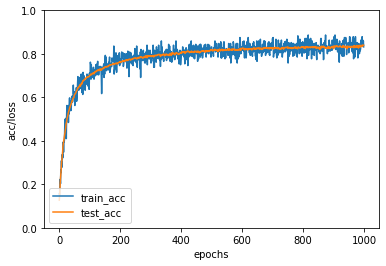

In [ ]:
x = np.arange(len(history["train_acc"]))

plt.plot(x, history["train_acc"], label="train_acc")
plt.plot(x, history["test_acc"], label="test_acc")
# plt.plot(x, history["train_loss"], label="train_loss")
# plt.plot(x, history["test_loss"], label="test_loss")

plt.xlabel("epochs")
plt.ylabel("acc/loss")
plt.ylim(0, 1.0)

plt.legend(loc="lower left")

plt.show()

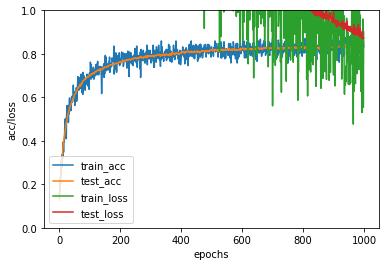

In [ ]:
x = np.arange(len(history["train_acc"]))

plt.plot(x, history["train_acc"], label="train_acc")
plt.plot(x, history["test_acc"], label="test_acc")
plt.plot(x, history["train_loss"], label="train_loss")
plt.plot(x, history["test_loss"], label="test_loss")

plt.xlabel("epochs")
plt.ylabel("acc/loss")
plt.ylim(0, 1.0)

plt.legend(loc="lower left")

plt.show()

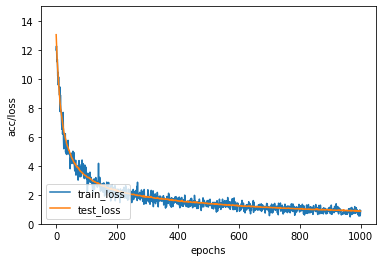

In [ ]:
x = np.arange(len(history["train_acc"]))

# plt.plot(x, history["train_acc"], label="train_acc")
# plt.plot(x, history["test_acc"], label="test_acc")
plt.plot(x, history["train_loss"], label="train_loss")
plt.plot(x, history["test_loss"], label="test_loss")

plt.xlabel("epochs")
plt.ylabel("acc/loss")
plt.ylim(0, 15.0)

plt.legend(loc="lower left")

plt.show()